***Imports***

In [41]:
import numpy as np
import random
import gym
import glob
import io
import time
from tqdm import tqdm
from random import sample
import matplotlib.pyplot as plt
from IPython.display import clear_output

***Environment***

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


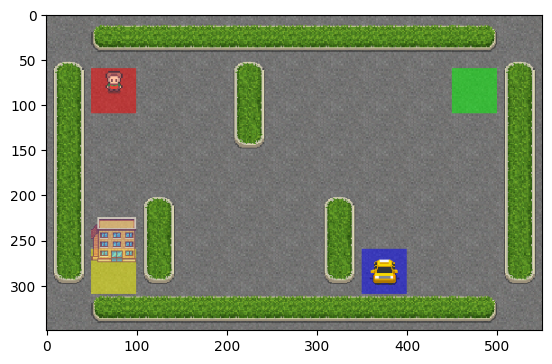

462
passenger is at red and destination is at yellow and taxi is at 4,3.


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


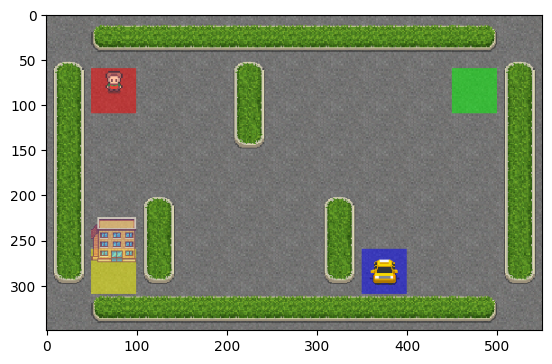

In [42]:
'''
importing taxi as environment
'''

env=gym.make('Taxi-v3')
state=env.reset()
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(state)

def give_positions(state):
  passenger=(state//4)%5
  destination = state%4
  taxi_col=(state//20)%5
  taxi_row=state//100
  return passenger,destination,taxi_row,taxi_col

passenger_location,destination_location,taxi_r,taxi_c=give_positions(state)

locations=['red','green','yellow','blue']

print('passenger is at {} and destination is at {} and taxi is at {},{}.'.format(locations[passenger_location],locations[destination_location],taxi_r,taxi_c))

next_state,reward,done,_=env.step(0)
plt.imshow(env.render(mode="rgb_array"))
plt.show()

***Softmax***

In [43]:
def softmax(Q_values,tau):
  Q_values /= tau
  exp_vals = np.exp(Q_values - np.max(Q_values))
  exp_vals /= np.sum(exp_vals)
  return np.argmax(exp_vals)

***Epsilon_greedy***

In [44]:
def epsilon_greedy(Q_values,eps):
  if np.random.rand() > eps:
    return np.argmax(Q_values)
  else :
    return np.random.choice(np.arange(0,len(Q_values)))

***Options***

In [45]:
gamma=0.9
episodes=2500
epsilon = 0.1
option_values={'red':(0,0),'green':(0,4),'yellow':(4,0),'blue':(4,3)}
option_action_table={}
option_action_table['red']=[[0,3,0,0,0],
                            [1,3,3,3,3],
                            [1,1,1,1,1],
                            [1,1,1,1,1],
                            [1,1,1,1,1]]
option_action_table['green']=[[0,0,2,2,0],
                            [2,2,2,2,1],
                            [1,1,1,1,1],
                            [1,1,1,1,1],
                            [1,1,1,1,1]]
option_action_table['yellow']=[[0,0,0,0,0],
                            [0,0,0,0,0],
                            [0,3,3,3,3],
                            [0,1,1,1,1],
                            [1,1,1,1,1]]
option_action_table['blue']=[[0,0,0,0,0],
                            [0,0,0,0,0],
                            [2,2,2,0,3],
                            [1,1,1,0,1],
                            [1,1,1,1,1]]


***Intra-Option Q learning***

In [46]:
def IntraOptionQ_learning(option_action_table, env, episodes, alpha, gamma, tau):
    Q_values_IOQL = np.zeros((500, 10))
    final_rewards_IOQL = np.zeros(episodes)
    for episode in range(episodes):
        episode_reward = 0
        state = env.reset()
        passenger, destination, _, _ = give_positions(state)
        while passenger == destination:  # to get a case where start and end are not the same
            state = env.reset()
            passenger, destination, _, _ = give_positions(state)
        done = False
        while not done:
            action = softmax(Q_values_IOQL[state], tau)
            # action = epsilon_greedy(Q_values_IOQL[state],epsilon)
            if action < 6:
                next_state, reward, episode_done, _ = env.step(action)
                Q_values_IOQL[state][action] += alpha * (reward + gamma*np.max(Q_values_IOQL[next_state]) - Q_values_IOQL[state][action])
                episode_reward += reward
                state = next_state
                if reward == 20 or episode_done:
                    done = True
            else:
                option_done = False
                while True:
                    _,_,taxi_row, taxi_col = give_positions(state)
                    next_state, reward, option_done, _ = env.step(option_action_table[locations[action - 6]][taxi_row][taxi_col])
                    episode_reward += reward
                    if option_done or reward == 20:
                        done = True
                        break
                    _,_,next_taxi_row, next_taxi_col = give_positions(next_state)
                    if (next_taxi_row, next_taxi_col) == option_values[locations[action - 6]]:
                      for i in range(4):
                        if option_action_table[locations[i]][taxi_row][taxi_col] == option_action_table[locations[action - 6]][taxi_row][taxi_col]:
                          Q_values_IOQL[state][i+6]+=alpha*(reward + gamma*np.max(Q_values_IOQL[next_state]) - Q_values_IOQL[state][i+6])
                      option_done=True
                      done = True
                      break
                    if option_done==True:
                      break
                    for i in range(4):
                      if option_action_table[locations[i]][taxi_row][taxi_col] == option_action_table[locations[action - 6]][taxi_row][taxi_col]:
                        Q_values_IOQL[state][i+6]+=alpha*(reward + gamma*Q_values_IOQL[next_state][i+6] - Q_values_IOQL[state][i+6])
                    state = next_state
                    if reward == 20 or episode_done:
                      done = True
                      break
        final_rewards_IOQL[episode] = episode_reward

    return final_rewards_IOQL, Q_values_IOQL

***Fine tuning***

In [47]:
alphaList = [0.1,0.4,0.06,0.8,0,9] #[0.95,0.935,0.9,0.92,0.927] #,0.3,0.5,0.7,0.9  ,0.3,0.6
tauList = [0.9759,1,1.2,0.8,0.1] #[1,1.2,1.16,1.1,1.25] #0.1,0.5,0.7,1,2.5  ,0.5,0.2,
rewardList=[]
for alpha in alphaList:
  for tau in tauList:
    # epsilon = t
    ret_r,_=IntraOptionQ_learning(option_action_table,env,episodes,alpha,gamma,tau)
    rewardList.append(np.average(ret_r))

print('the rewards for all the permutaions of hyperparameters are as follows')
print(rewardList)

ind=np.argmax(np.array(rewardList))
best_alpha=alphaList[ind//5]#//1
best_tau=tauList[ind%5]#%5
best_avg_reward=rewardList[ind]
print(f'Basing on rewards, best hyperparameters are {best_alpha} as alpha and {best_tau} as tau with average reward as {best_avg_reward}.')

<ipython-input-43-365e7ee6a906>:2: RuntimeWarning: overflow encountered in divide
  Q_values /= tau
<ipython-input-43-365e7ee6a906>:3: RuntimeWarning: invalid value encountered in subtract
  exp_vals = np.exp(Q_values - np.max(Q_values))
<ipython-input-46-31b7dd376bf9>:23: RuntimeWarning: invalid value encountered in scalar add
  Q_values_IOQL[state][action] += alpha * (reward + gamma*np.max(Q_values_IOQL[next_state]) - Q_values_IOQL[state][action])
<ipython-input-46-31b7dd376bf9>:51: RuntimeWarning: invalid value encountered in scalar add
  Q_values_IOQL[state][i+6]+=alpha*(reward + gamma*Q_values_IOQL[next_state][i+6] - Q_values_IOQL[state][i+6])
<ipython-input-46-31b7dd376bf9>:43: RuntimeWarning: invalid value encountered in scalar add
  Q_values_IOQL[state][i+6]+=alpha*(reward + gamma*np.max(Q_values_IOQL[next_state]) - Q_values_IOQL[state][i+6])
<ipython-input-46-31b7dd376bf9>:51: RuntimeWarning: invalid value encountered in scalar subtract
  Q_values_IOQL[state][i+6]+=alpha*(rewa

the rewards for all the permutaions of hyperparameters are as follows
[-36.4268, -38.3172, -53.1188, -107.0536, -271.7992, -37.574, -37.3208, -50.044, -93.5052, -280.414, -34.5308, -38.7316, -54.834, -108.1476, -293.1348, -33.6832, -34.4644, -49.4064, -86.8096, -220.9396, -200.0, -200.0, -200.0, -200.0, -200.0, -111.5816, -136.2012, -108.1376, -116.0164, -645.6308]
Basing on rewards, best hyperparameters are 0.8 as alpha and 0.9759 as tau with average reward as -33.6832.


***Plots***

<Figure size 640x480 with 0 Axes>

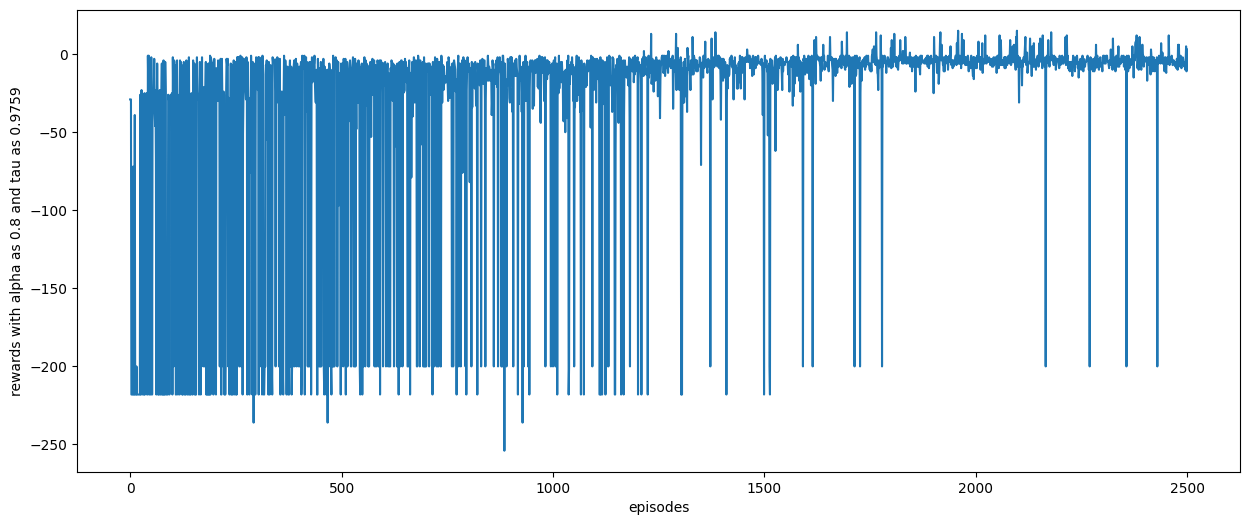

In [48]:
# best_tau=0.9759
# best_alpha=0.8
final_reward,Q_values=IntraOptionQ_learning(option_action_table,env,episodes,best_alpha,gamma,best_tau)
plt.figure()
plt.figure(figsize=(15,6))
plt.xlabel('episodes')
plt.ylabel(f'rewards with alpha as {best_alpha} and tau as {best_tau}')
plt.plot(final_reward)

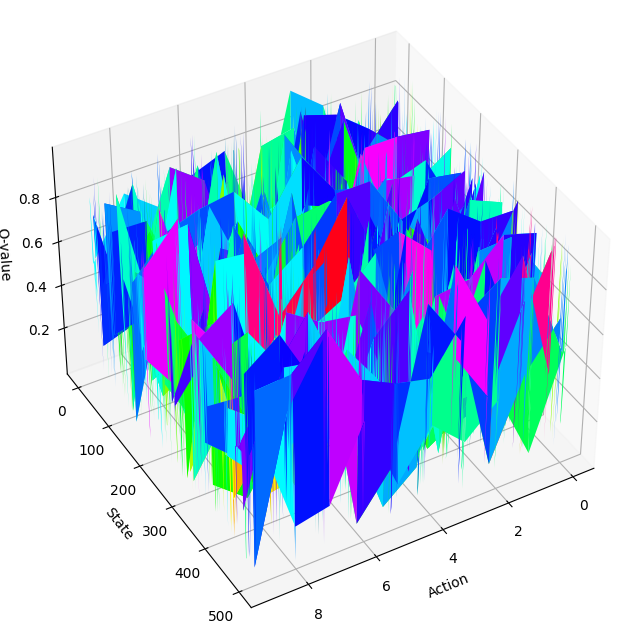

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
Q_values = np.random.rand(500, 10)
rows, cols = Q_values.shape
x_coords, y_coords = np.meshgrid(np.arange(cols), np.arange(rows))
z_values = Q_values.flatten()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_coords, y_coords, Q_values, cmap='hsv')
ax.set_xlabel('Action')
ax.set_ylabel('State')
ax.set_zlabel('Q-value')
ax.view_init(elev=40, azim=60)
plt.show()

***Alternate Options***

In [50]:
locations=['left_C','top_C','right_C','bottom_C']
option_values={'left_C':(2,0),'top_C':(0,2),'right_C':(2,4),'bottom_C':(4,2)}
option_action_table1={}
'''
0 down
1 up
2 right
3 left
'''
option_action_table1['left_C']=[[0,0,0,0,0],
                            [0,0,0,0,0],
                            [3,3,3,3,3],
                            [1,1,1,1,1],
                            [1,1,1,1,1]]
option_action_table1['top_C']=[[0,0,1,3,3],
                            [0,0,1,3,3],
                            [2,2,1,3,3],
                            [1,1,1,1,1],
                            [1,1,1,1,1]]
option_action_table1['right_C']=[[0,0,0,0,0],
                            [0,0,0,0,0],
                            [2,2,2,2,2],
                            [1,1,1,1,1],
                            [1,1,1,1,1]]
option_action_table1['bottom_C']=[[0,0,0,0,0],
                            [0,0,0,0,0],
                            [2,2,0,3,3],
                            [1,2,0,1,1],
                            [1,2,0,1,1]]

***Fine tuning for alternte options***

In [51]:
alphaList = [0.1,0.4,0.06,0.8,0,9] #[0.95,0.935,0.9,0.92,0.927] #,0.3,0.5,0.7,0.9  ,0.3,0.6
tauList = [0.9759,1,1.2,0.8,0.1] #[1,1.2,1.16,1.1,1.25] #0.1,0.5,0.7,1,2.5  ,0.5,0.2,
rewardList=[]
for alpha in alphaList:
  for tau in tauList:
    # epsilon = t
    ret_r,_=IntraOptionQ_learning(option_action_table1,env,episodes,alpha,gamma,tau)
    rewardList.append(np.average(ret_r))

print('the rewards for all the permutaions of hyperparameters are as follows')
print(rewardList)

ind=np.argmax(np.array(rewardList))
best_alpha=alphaList[ind//5]#//1
best_tau=tauList[ind%5]#%5
best_avg_reward=rewardList[ind]
print(f'Basing on rewards, best hyperparameters are {best_alpha} as alpha and {best_tau} as tau with average reward as {best_avg_reward}.')

<ipython-input-43-365e7ee6a906>:2: RuntimeWarning: overflow encountered in divide
  Q_values /= tau
<ipython-input-43-365e7ee6a906>:3: RuntimeWarning: invalid value encountered in subtract
  exp_vals = np.exp(Q_values - np.max(Q_values))
<ipython-input-46-31b7dd376bf9>:23: RuntimeWarning: invalid value encountered in scalar add
  Q_values_IOQL[state][action] += alpha * (reward + gamma*np.max(Q_values_IOQL[next_state]) - Q_values_IOQL[state][action])
<ipython-input-46-31b7dd376bf9>:43: RuntimeWarning: invalid value encountered in scalar add
  Q_values_IOQL[state][i+6]+=alpha*(reward + gamma*np.max(Q_values_IOQL[next_state]) - Q_values_IOQL[state][i+6])
<ipython-input-46-31b7dd376bf9>:51: RuntimeWarning: invalid value encountered in scalar add
  Q_values_IOQL[state][i+6]+=alpha*(reward + gamma*Q_values_IOQL[next_state][i+6] - Q_values_IOQL[state][i+6])
<ipython-input-46-31b7dd376bf9>:23: RuntimeWarning: invalid value encountered in scalar subtract
  Q_values_IOQL[state][action] += alpha 

the rewards for all the permutaions of hyperparameters are as follows
[-10.806, -11.3584, -15.4704, -57.1828, -194.3048, -10.8544, -10.4548, -15.0788, -40.14, -218.9112, -10.706, -11.6992, -15.3128, -52.5636, -204.9804, -10.12, -10.2836, -14.5788, -40.6532, -173.6856, -200.0, -200.0, -200.0, -200.0, -200.0, -82.4096, -144.6908, -133.0688, -94.6076, -641.5656]
Basing on rewards, best hyperparameters are 0.8 as alpha and 0.9759 as tau with average reward as -10.12.


***Plots for alternate options***

<Figure size 640x480 with 0 Axes>

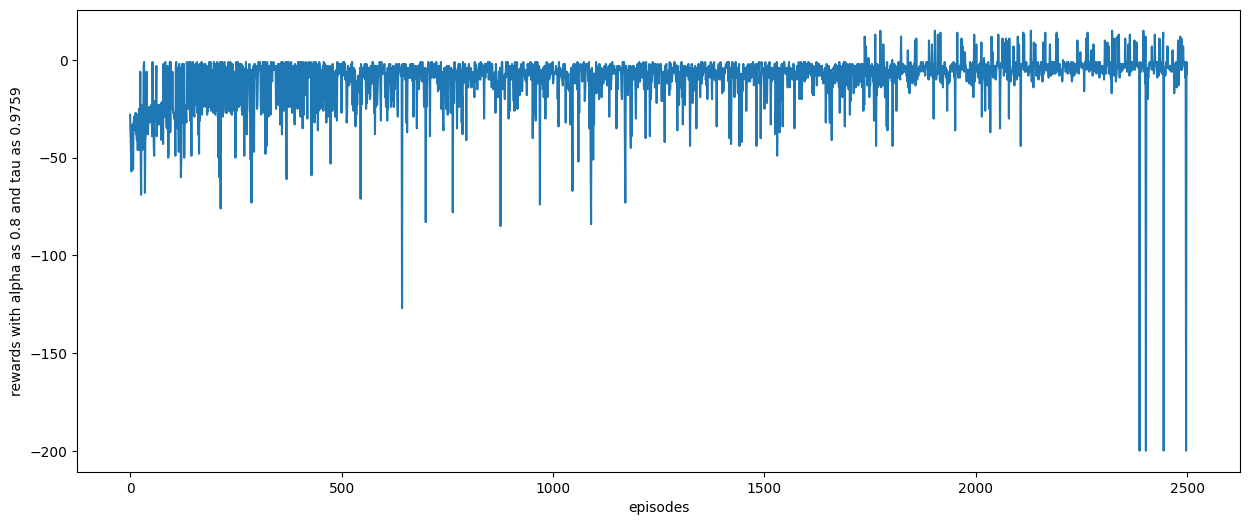

In [52]:
# best_tau=0.9759
# best_alpha=0.8
final_reward,Q_values=IntraOptionQ_learning(option_action_table1,env,episodes,best_alpha,gamma,best_tau)
plt.figure()
plt.figure(figsize=(15,6))
plt.xlabel('episodes')
plt.ylabel(f'rewards with alpha as {best_alpha} and tau as {best_tau}')
plt.plot(final_reward)

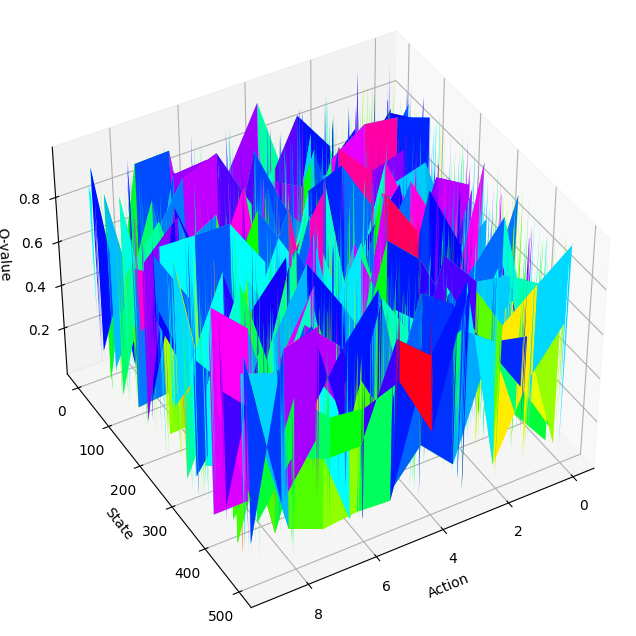

In [53]:
Q_values = np.random.rand(500, 10)
rows, cols = Q_values.shape
x_coords, y_coords = np.meshgrid(np.arange(cols), np.arange(rows))
z_values = Q_values.flatten()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_coords, y_coords, Q_values, cmap='hsv')
ax.set_xlabel('Action')
ax.set_ylabel('State')
ax.set_zlabel('Q-value')
ax.view_init(elev=40, azim=60)
plt.show()